# Beggining of Code

In [1]:
# standard and PIL Image
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

#Imblearn for SMOTE oversamping 
#from imblearn.over_sampling import SMOTENC

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

IMAGE_PATH = 'archive/' 

### Ingesting/Processing Image Data and Metadata from Kaggle Downloads

In [2]:
def preprocessing_labels():
    image_values_df = pd.read_csv('archive/ISIC_2019_Training_GroundTruth.csv')
    image_values_df["type"] = image_values_df[["MEL", "NV", "BCC", "AK", "BKL", "DF", "SCC", "VASC"]].idxmax(axis=1)
    image_values_df = image_values_df[['image', 'type']]
    print("Number of rows in Image data set before Merge:", len(image_values_df))
    metadata_df = pd.read_csv('archive/ISIC_2019_Training_Metadata.csv')
    print("Number of rows in Metadata data set before Merge:", len(metadata_df))
    image_values_df = image_values_df.merge(metadata_df, on = 'image', how = 'inner')
    print("Number of rows in Merged Dataset:", len(image_values_df))
    return image_values_df

In [3]:
labels_df = preprocessing_labels()
labels_df

Number of rows in Image data set before Merge: 25331
Number of rows in Metadata data set before Merge: 25331
Number of rows in Merged Dataset: 25331


image type  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000   NV        55.0      anterior torso          NaN  female
1      ISIC_0000001   NV        30.0      anterior torso          NaN  female
2      ISIC_0000002  MEL        60.0     upper extremity          NaN  female
3      ISIC_0000003   NV        30.0     upper extremity          NaN    male
4      ISIC_0000004  MEL        80.0     posterior torso          NaN    male
...             ...  ...         ...                 ...          ...     ...
25326  ISIC_0073247  BCC        85.0           head/neck  BCN_0003925  female
25327  ISIC_0073248  BKL        65.0      anterior torso  BCN_0001819    male
25328  ISIC_0073249  MEL        70.0     lower extremity  BCN_0001085    male
25329  ISIC_0073251   NV        55.0         palms/soles  BCN_0002083  female
25330  ISIC_0073254  BKL        50.0     upper extremity  BCN_0001079    male

[25331 rows x 6 columns]

Sample of images in data:


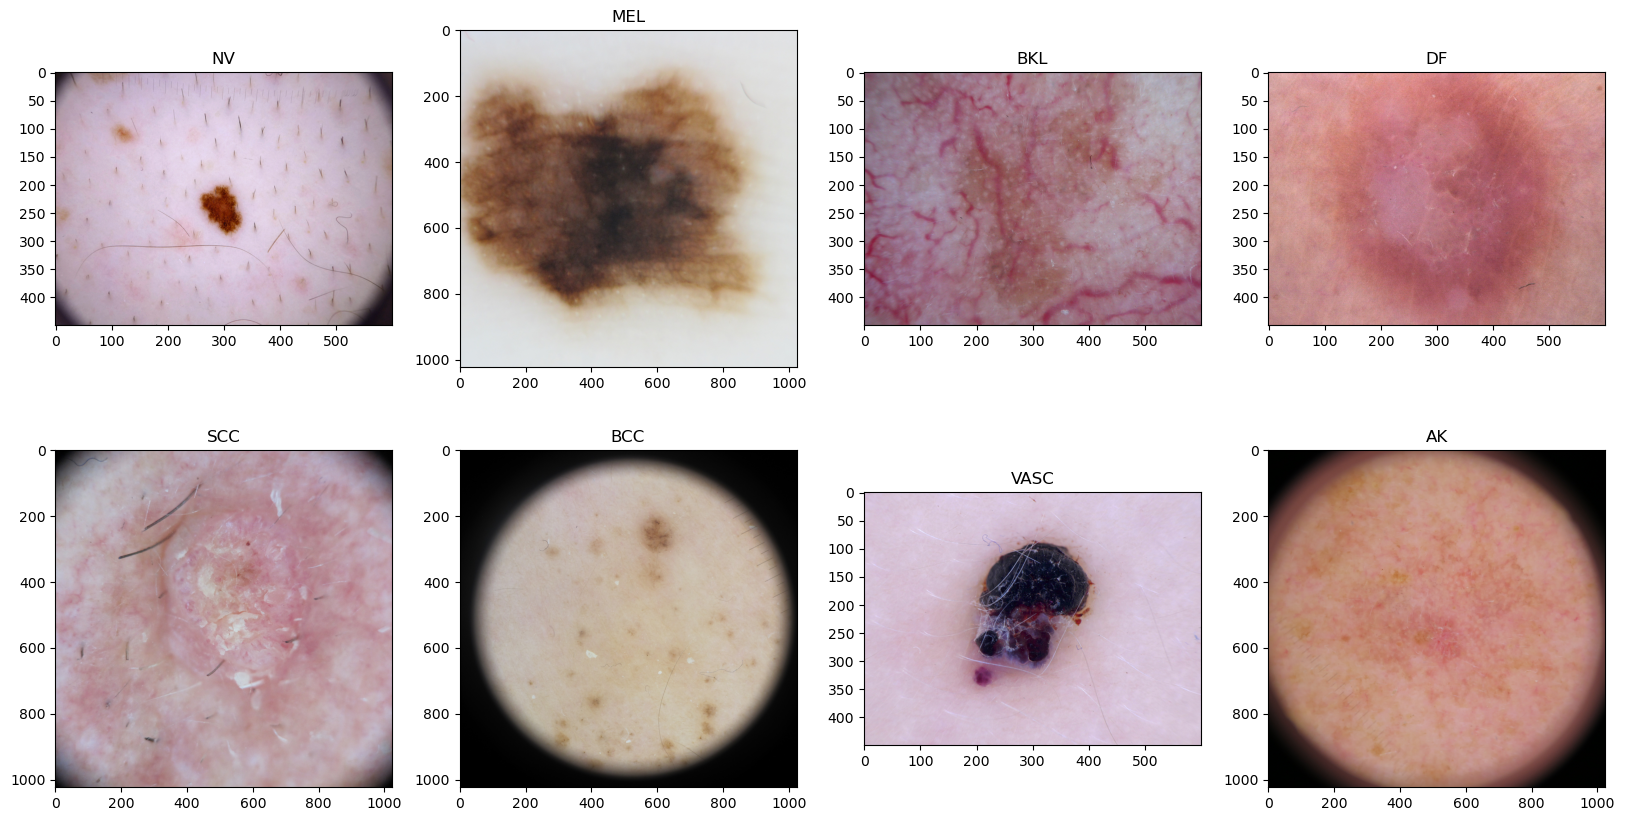

In [4]:
# read image
images = []
class_images = []
counter = 0
print('Sample of images in data:')
for folder in labels_df['type'].unique():
    counter = 0
    for idx, img in enumerate(os.listdir(IMAGE_PATH + folder + '/')):
        img = load_img(
        IMAGE_PATH + folder + '/' + img)
        images.append(img)
        if counter == 0:
            class_images.append([img, folder])
            counter+=1

indx=0           
nrows, ncols = 2,4 #print first image of each class
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(class_images[indx][0])
        axs[i,j].set_title(class_images[indx][1])
        indx+=1

## Visualizations and EDA

NV: 12875
MEL: 4522
BCC: 3323
BKL: 2624
AK: 867
SCC: 628
VASC: 253
DF: 239
Proportion of examples in NV Class: 50.83%


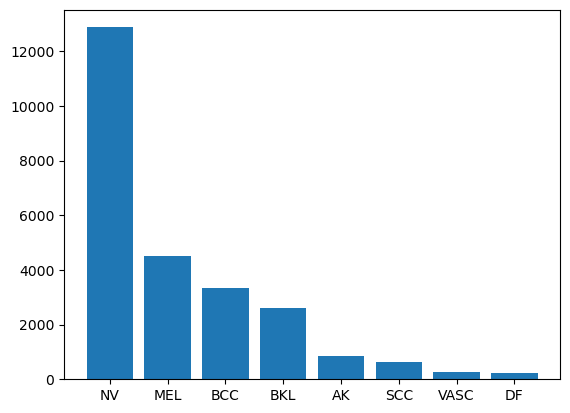

In [5]:
# Number of examples in Each Class
plt.bar(x = labels_df['type'].value_counts().index, height = labels_df['type'].value_counts())
for i in labels_df['type'].value_counts().index:
    print(i, ": ", labels_df['type'].value_counts()[i], sep = '')  
print("Proportion of examples in NV Class: ", 
      round(labels_df['type'].value_counts()['NV'] / len(labels_df)*100, 2), '%', sep = '')

In [6]:
new_df = labels_df[['type','image', 'anatom_site_general','sex']]
new_df = pd.concat([new_df, pd.get_dummies(new_df['anatom_site_general'])], axis=1)
new_df = pd.concat([new_df, pd.get_dummies(new_df['sex'])], axis=1) 
grouped = new_df.groupby('type').agg('sum')
grouped_short = grouped[['anterior torso', 'head/neck','lateral torso',
                                                        'lower extremity','oral/genital', 'palms/soles',
                                                        'posterior torso', 'upper extremity']]
deep_group = new_df.groupby(['type', 'anatom_site_general']).agg('sum')
sex_deep_group = new_df.groupby(['type', 'sex']).agg('sum')
deep_group = deep_group[['anterior torso', 'head/neck', 'lateral torso', 'lower extremity',
       'oral/genital', 'palms/soles', 'posterior torso', 'upper extremity']]
deep_group['total'] = deep_group.sum(axis = 1)
sex_deep_group['total'] = sex_deep_group[['male', 'female']].sum(axis = 1)
totals = sex_deep_group.reset_index().groupby('type').agg('sum')['total']
sex_deep_group['total'] = sex_deep_group[['male', 'female']].sum(axis = 1)
the_totals= []
for i in range(len(sex_deep_group)):
  curr_val = sex_deep_group.iloc[i, :]['total']
  if i % 2 == 0:
    the_totals.append(curr_val + sex_deep_group.iloc[i + 1, :]['total'])
  else:
    the_totals.append(curr_val + sex_deep_group.iloc[i - 1, :]['total'])
sex_deep_group['total_prop'] = sex_deep_group['total'].values / np.array(the_totals)
super_deep = new_df.groupby(['type', 'sex', 'anatom_site_general']).agg('sum')
super_deep['total'] = super_deep[['male', 'female']].sum(axis = 1)
totals = super_deep.reset_index().groupby('type').agg('sum')['total']
the_totals= []
for i in range(len(super_deep)):
  curr_val = super_deep.iloc[i, :]['total']
  if i % 2 == 0:
    the_totals.append(curr_val + super_deep.iloc[i + 1, :]['total'])
  else:
    the_totals.append(curr_val + super_deep.iloc[i - 1, :]['total'])
super_deep['total_prop'] = super_deep['total'].values / np.array(the_totals)

/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/1234393582.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = new_df.groupby('type').agg('sum')
/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/1234393582.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deep_group = new_df.groupby(['type', 'anatom_site_general']).agg('sum')
/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/1234393582.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify nu

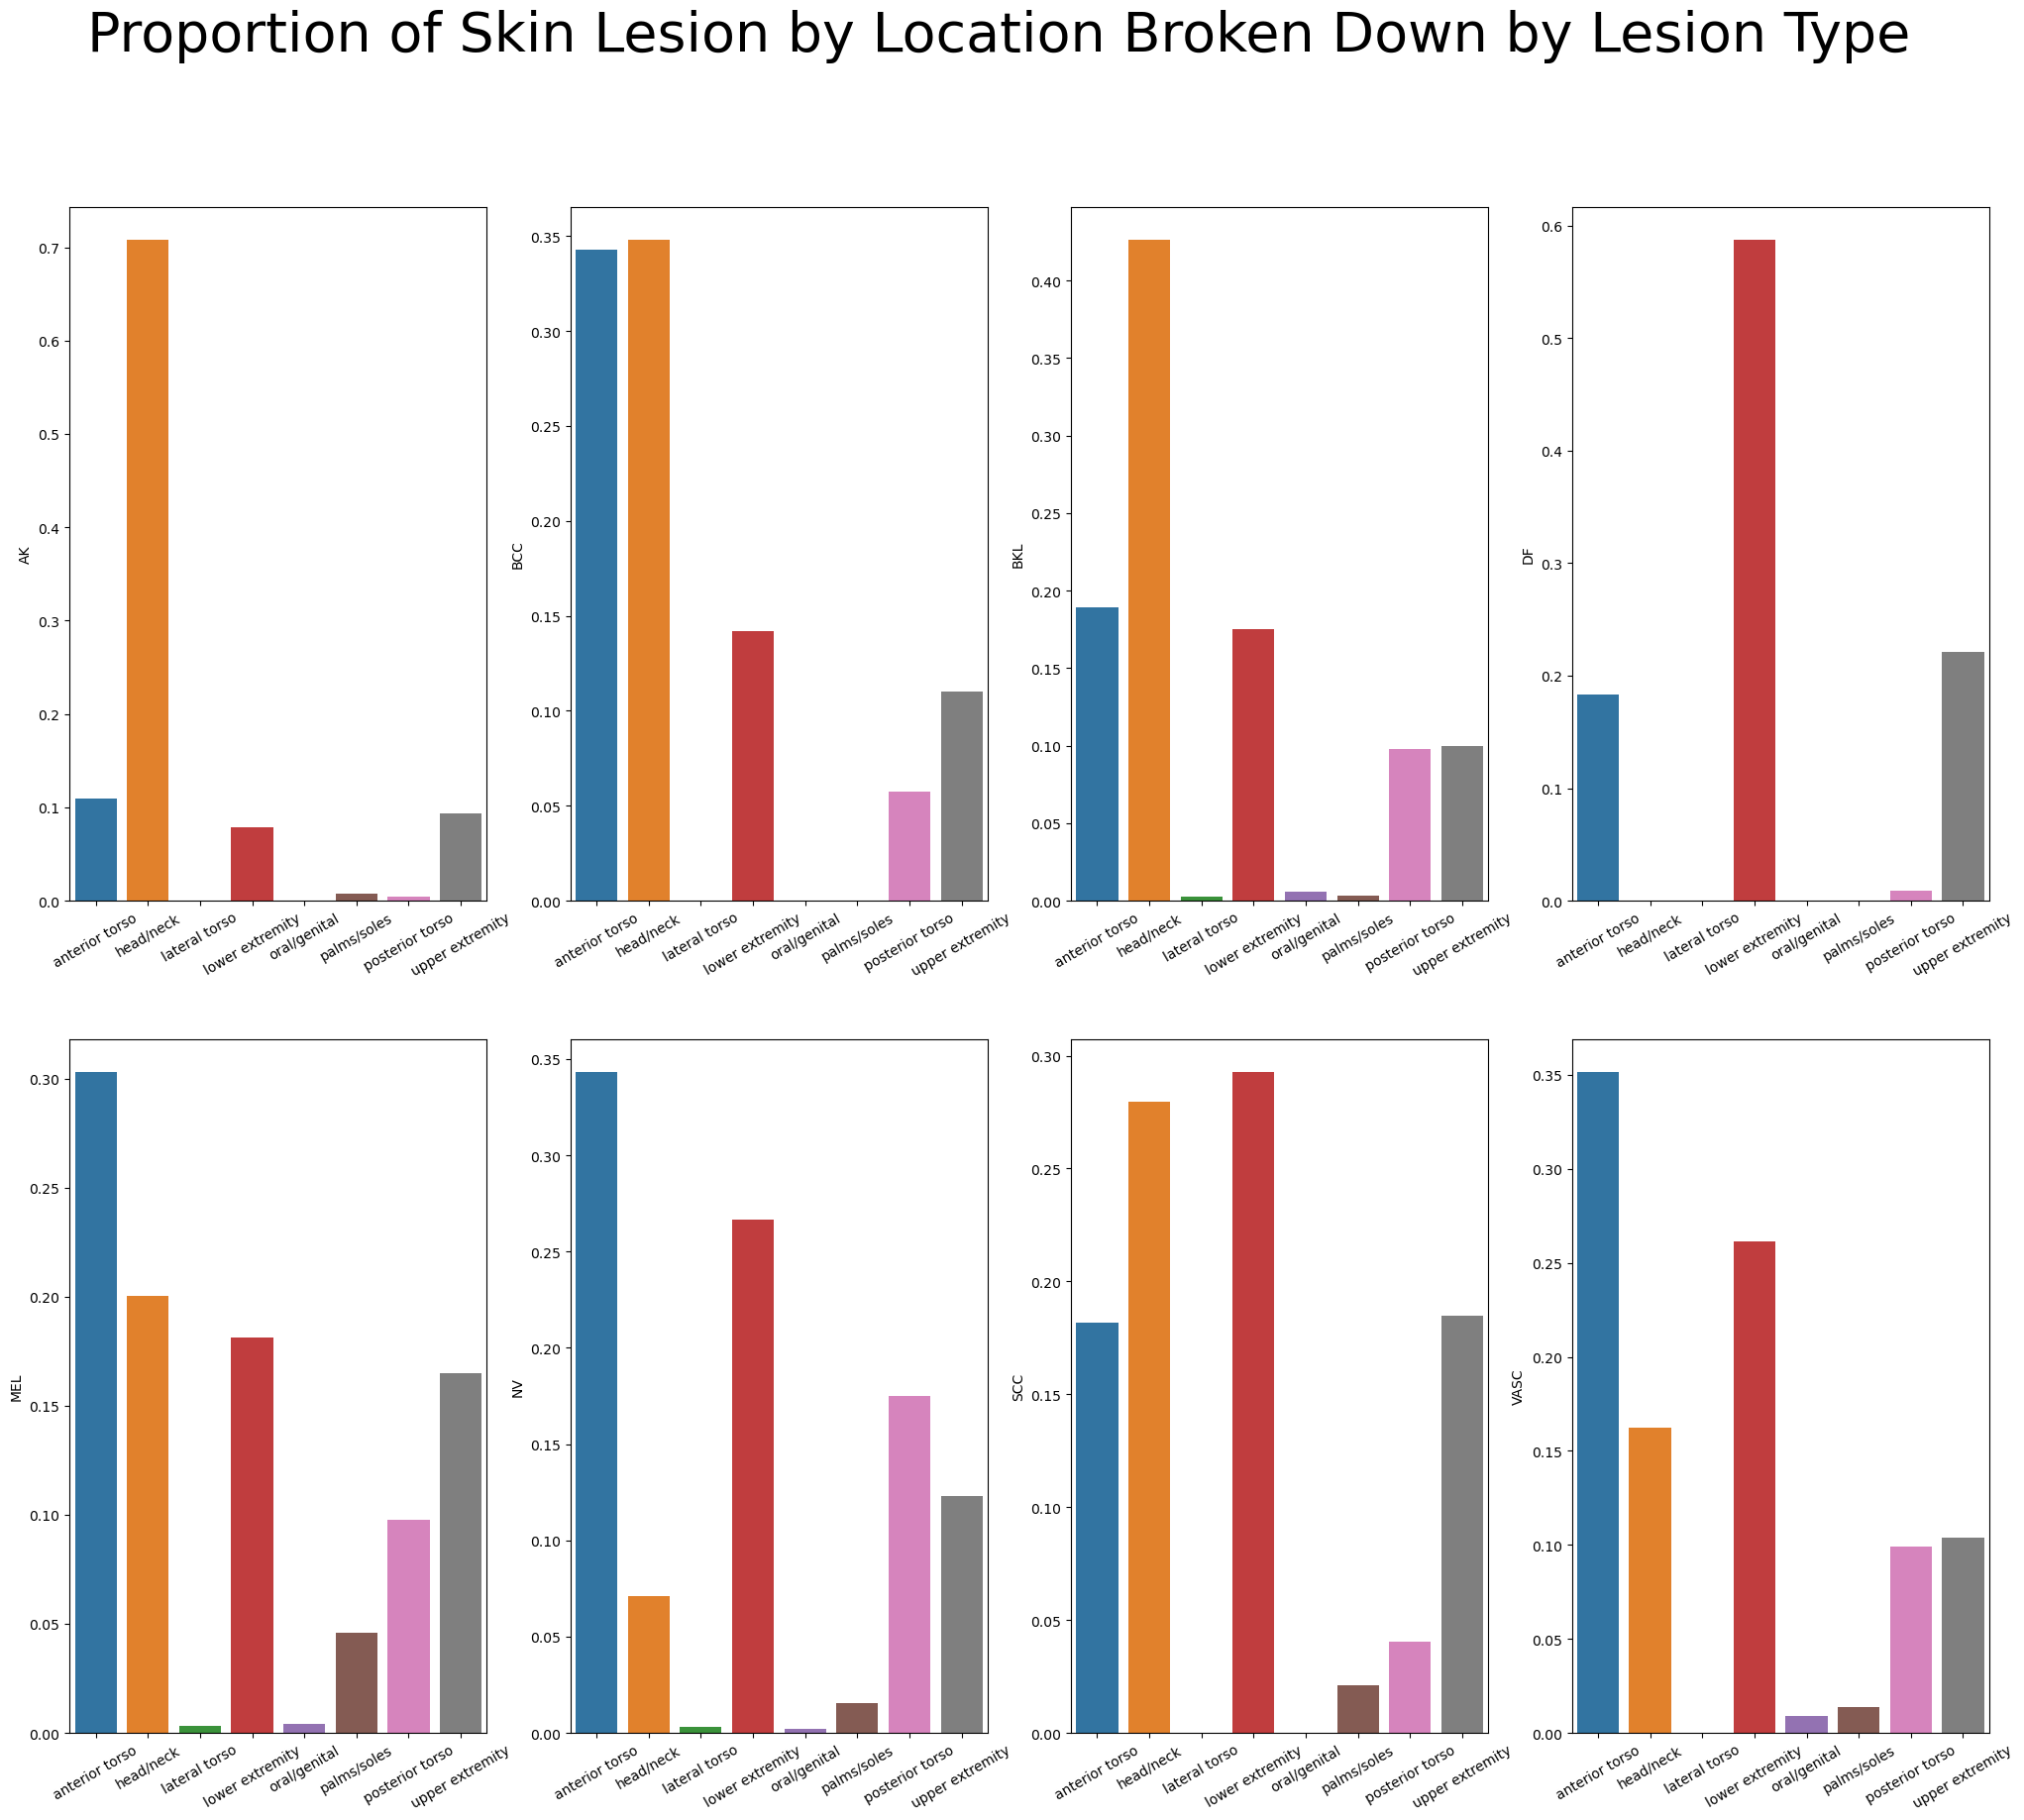

In [7]:
#creating some plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25,20))
fig.suptitle("Proportion of Skin Lesion by Location Broken Down by Lesion Type", size = 40)
row = 0
column = 0
for i in range(len(grouped_short.index)):
    bar = sns.barplot(x = grouped_short.columns,
                      y = grouped_short.iloc[i,:] / grouped_short[grouped_short.index == grouped_short.index[i]].sum(axis = 1)[0],
                      ax = axes[row][column])
    bar.set_xticklabels(labels = grouped_short.columns,
                        rotation=30)
    column += 1
    if column == 4:
        row = 1
        column = 0

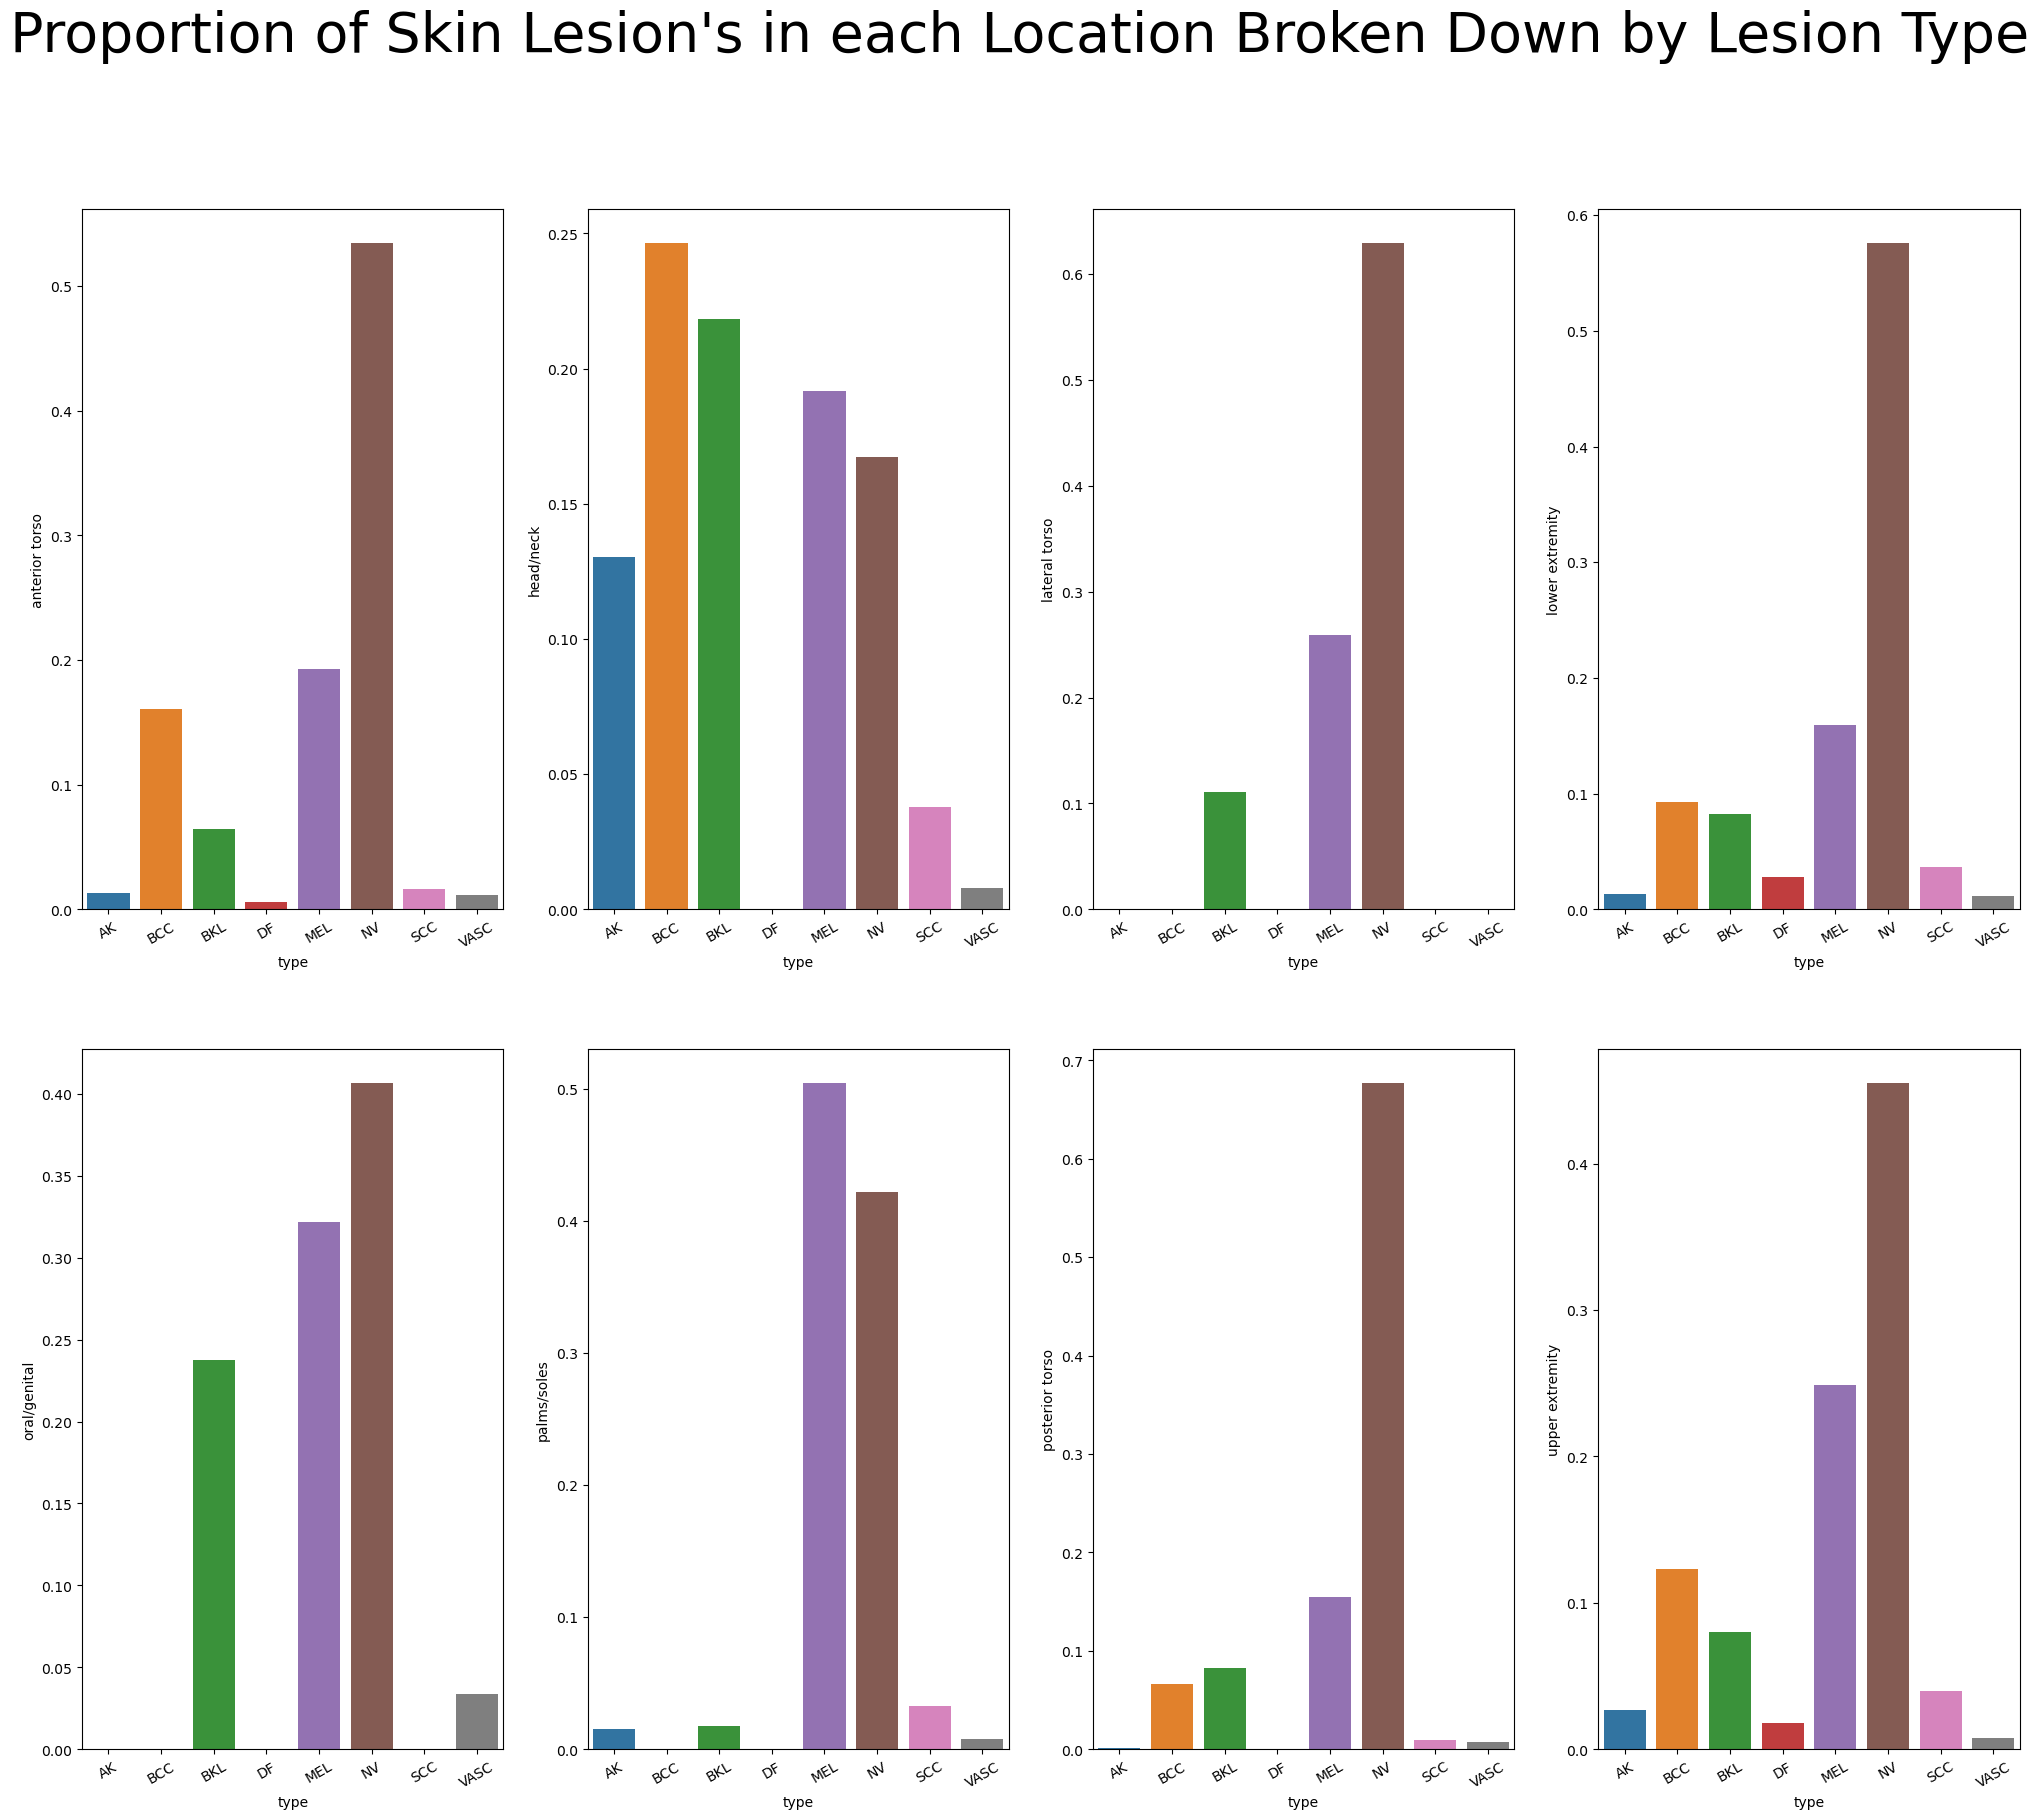

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25,20))
fig.suptitle("Proportion of Skin Lesion's in each Location Broken Down by Lesion Type", size = 40)
row = 0
column = 0
for i in range(len(grouped_short.columns)):
    bar = sns.barplot(x = grouped_short.index,
                      y = grouped_short.iloc[:,i] / grouped_short.iloc[:,i].sum(),
                      ax = axes[row][column])
    bar.set_xticklabels(labels = grouped_short.index,
                        rotation=30)
    column += 1
    if column == 4:
        row = 1
        column = 0

Text(0.5, 1.0, "Proportion of Skin Lesion's in each Location Broken Down by Lesion Type")

<Figure size 3000x3000 with 0 Axes>

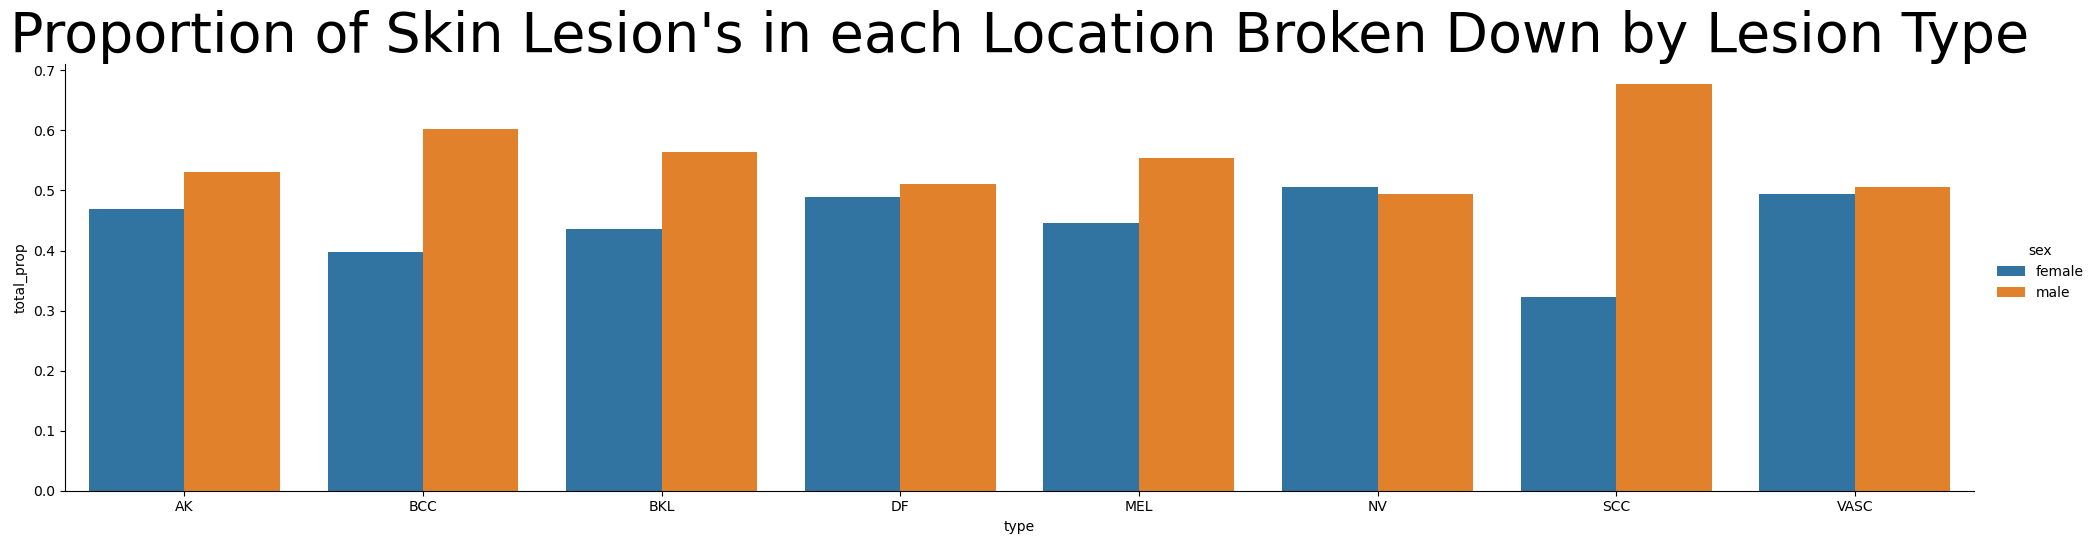

In [9]:
plt.figure(figsize=(30, 30))
sns.catplot(x='type', y='total_prop', hue='sex', data=sex_deep_group.reset_index(), kind='bar', aspect = 40/10)
plt.title("Proportion of Skin Lesion's in each Location Broken Down by Lesion Type", size = 40)

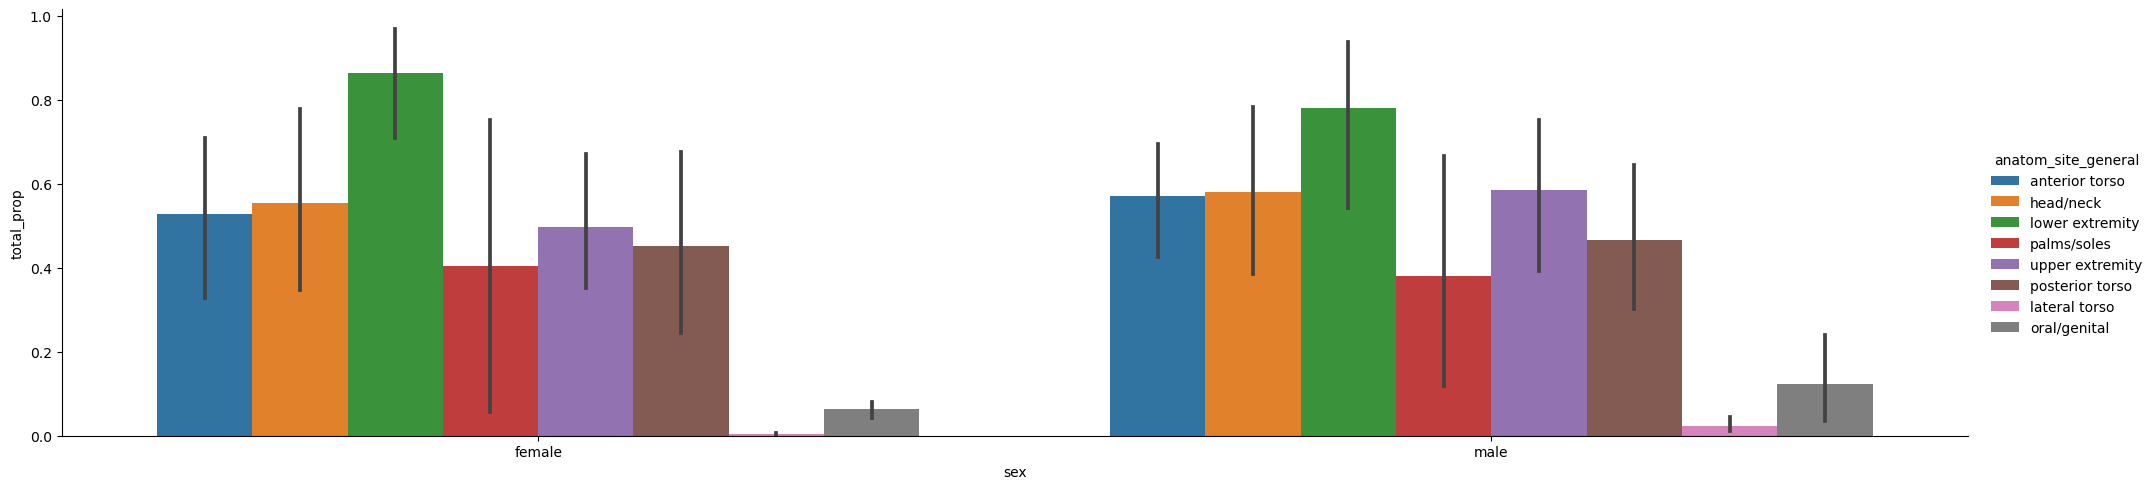

In [10]:
sns.catplot(x='sex', y='total_prop', hue='anatom_site_general', data=super_deep.reset_index(), kind='bar', aspect = 40/10)

# Melanoma CNN Classifier: MEL or non-MEL

In [11]:
is_melanoma = [1 if i == 'MEL' else 0 for i in labels_df['type']]
mel_df = labels_df[['image', 'age_approx', 'anatom_site_general','sex']]
mel_df["is_mel"] = is_melanoma
mel_df

/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/2894563176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mel_df["is_mel"] = is_melanoma


image  age_approx anatom_site_general     sex  is_mel
0      ISIC_0000000        55.0      anterior torso  female       0
1      ISIC_0000001        30.0      anterior torso  female       0
2      ISIC_0000002        60.0     upper extremity  female       1
3      ISIC_0000003        30.0     upper extremity    male       0
4      ISIC_0000004        80.0     posterior torso    male       1
...             ...         ...                 ...     ...     ...
25326  ISIC_0073247        85.0           head/neck  female       0
25327  ISIC_0073248        65.0      anterior torso    male       0
25328  ISIC_0073249        70.0     lower extremity    male       1
25329  ISIC_0073251        55.0         palms/soles  female       0
25330  ISIC_0073254        50.0     upper extremity    male       0

[25331 rows x 5 columns]

In [12]:
mel_df.groupby('sex').agg('mean')

/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/2323810385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mel_df.groupby('sex').agg('mean')


age_approx    is_mel
sex                         
female   51.219596  0.169797
male     56.493325  0.185233

In [13]:
mel_df.groupby('is_mel').agg('mean')

/var/folders/fg/ymd376wx6kl1hcm2x9vr_wtw0000gn/T/ipykernel_98506/964274437.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mel_df.groupby('is_mel').agg('mean')


age_approx
is_mel            
0        52.577113
1        60.720081

Not Melanoma: 20809
Melanoma: 4522
Proportion of examples in Melanoma Class: 17.85%


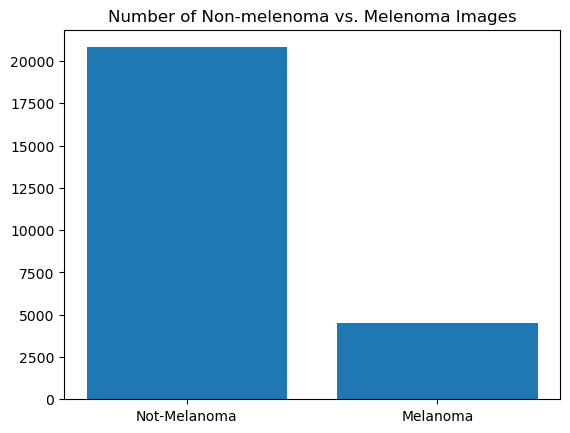

In [14]:
# Number of examples in Each Class
plt.bar(x = mel_df['is_mel'].value_counts().index, height = mel_df['is_mel'].value_counts())
plt.xticks(ticks = [0,1], labels = ['Not-Melanoma', 'Melanoma'])
plt.title('Number of Non-melenoma vs. Melenoma Images')
for i in mel_df['is_mel'].value_counts().index:
    if i == 0:
        print('Not Melanoma', ": ", mel_df['is_mel'].value_counts()[i], sep = '')  
    else:
        print('Melanoma', ": ", mel_df['is_mel'].value_counts()[i], sep = '')
print("Proportion of examples in Melanoma Class: ", 
    round(mel_df['is_mel'].value_counts()[1] / len(labels_df) * 100, 2), '%', sep = '')

### Sampling Techniques

In [15]:
# SAMPLING ATTEMPT 1: Equal Samples from each non melenoma class (289), and (289*7) samples from melenoma
np.random.seed(1234)

mel = labels_df[labels_df['type'] == "MEL"]
NV = labels_df[labels_df['type'] == 'NV']
BCC = labels_df[labels_df['type'] =='BCC']
BKL = labels_df[labels_df['type'] =='BKL']
AK = labels_df[labels_df['type'] =='AK']
SCC = labels_df[labels_df['type'] =='SCC']
VASC = labels_df[labels_df['type'] =='VASC']
DF = labels_df[labels_df['type'] =='DF']

sample_size = min(labels_df['type'].value_counts())

# randomly draw equal number of images from each classes based on the type with least number of images
temp_NV = []
temp_BCC = []
temp_BKL = []
temp_AK = []
temp_SCC = []
temp_VASC = []
temp_DF = []

temp_NV = list(np.random.choice(
    NV.image,
    size=sample_size,
    replace=True
))

temp_BCC = list(np.random.choice(
    BCC.image,
    size=sample_size,
    replace=True
))

temp_BKL = list(np.random.choice(
    BKL.image,
    size=sample_size,
    replace=True
))

temp_AK = list(np.random.choice(
    AK.image,
    size=sample_size,
    replace=True
))

temp_SCC = list(np.random.choice(
    SCC.image,
    size=sample_size,
    replace=True
))

temp_VASC = list(np.random.choice(
    VASC.image,
    size=sample_size,
    replace=True
))

temp_DF = list(np.random.choice(
    DF.image,
    size=sample_size,
    replace=True
))
# oversample images from melenoma class
temp_mel = list(np.random.choice(
    mel.image,
    size=sample_size * 7,
    replace=True
))

temp_not_mel = np.concatenate([temp_NV,temp_BCC,temp_BKL, temp_AK, temp_SCC, temp_VASC, temp_DF])


print(len(temp_mel), "\n", len(temp_not_mel))

1673 
 1673


In [16]:
#Sample Technique 2: eqal samples from melenoma and non-melenoma classes, type within non-melemona ignored
sample_size = round(len(mel_df[mel_df['is_mel'] == 1])/2)
print(sample_size)
temp_not_mel = mel_df[mel_df['is_mel'] == 0].sample(sample_size-400)
temp_mel = mel_df[mel_df['is_mel'] == 1].sample(sample_size-400)

2261


In [17]:
# Saple technique 3: SMOTE (DID NOT USE BECAUSE CASUED OVERFITTING, 
# KNN IN SMOTE NOT GIVING ACCURATE NEAREST NEIGHBORS AND THROWING OFF ANALYSIS)
"""sm = SMOTENC(random_state = 42, categorical_features = ['image', 'sex', 'anatom_site_general'])
np.random.seed(1234)
data2 = mel_df.dropna().sample(frac = .1)
x_data, y_data = sm.fit_resample(data2[['image', 'age_approx', 'anatom_site_general','sex']], data2['is_mel'])
x_data"""

"sm = SMOTENC(random_state = 42, categorical_features = ['image', 'sex', 'anatom_site_general'])\nnp.random.seed(1234)\ndata2 = mel_df.dropna().sample(frac = .1)\nx_data, y_data = sm.fit_resample(data2[['image', 'age_approx', 'anatom_site_general','sex']], data2['is_mel'])\nx_data"

### Data Processing

In [18]:
def preprocess_data_sampling_technique_1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 300, 225, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    
    y_mini = []
    images_mini = []
    count = 0
    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp tables created above for each diagnoses class
    for folder in labels_df['type'].unique():
        for idx, img in enumerate(os.listdir(IMAGE_PATH + folder + '/')):
            if img.split('.')[0] in temp_not_mel: #['image'].values:
                    y_mini.append(0)
            elif img.split('.')[0] in temp_mel: #['image'].values:
                    y_mini.append(1)
            else:
                continue

        
            # read image
            img = load_img(
                IMAGE_PATH + folder +'/'+ img,
                target_size=(300, 225)
            )
            
            # transform image to array
            img = img_to_array(img)
            # append to images
            images_mini.append(img)
    # stack images and transform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [19]:
def preprocess_data_sampling_technique_2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    
    y_mini = []
    images_mini = []
    count = 0
    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp tables created above for each diagnoses class
    for folder in labels_df['type'].unique():
        for idx, img in enumerate(os.listdir(IMAGE_PATH + folder + '/')):
            if img.split('.')[0] in temp_not_mel['image'].values:
                    y_mini.append(0)
            elif img.split('.')[0] in temp_mel['image'].values:
                    y_mini.append(1)
            else:
                continue

        
            # read image
            img = load_img(
                IMAGE_PATH + folder +'/'+ img,
                target_size=(200, 200)
            )
            
            # transform image to array
            img = img_to_array(img)
            # append to images
            images_mini.append(img)
    # stack images and transform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [20]:
# generate images and labels based on preprocess_data_part1() or preprocess_data_part2() function
mel_images_mini, mel_mini = preprocess_data_sampling_technique_2(IMAGE_PATH)

print(f"mel_images_mini shape {mel_images_mini.shape}")
print(f"mel_mini shape {mel_mini.shape}")

mel_images_mini shape (3722, 200, 200, 3)
mel_mini shape (3722,)


2022-12-06 10:50:37.903101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


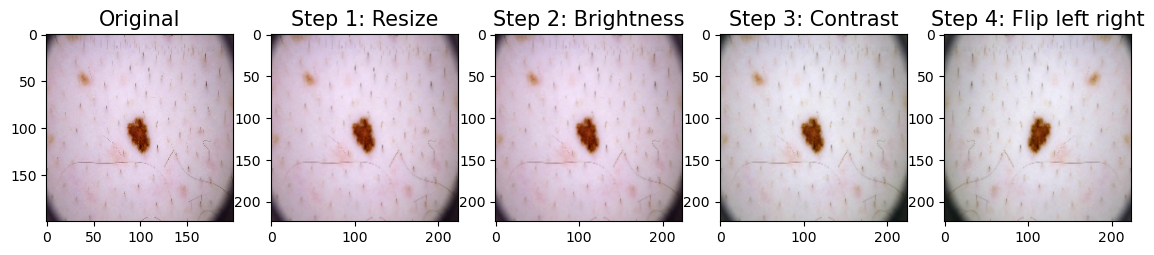

In [21]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = mel_images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

### More Processing & Image Augmentation

In [22]:
IMAGE_SIZE = (200,200)
CONTRAST_FACTOR = 4
DELTA = 0.5

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 200, 200, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 200, 200, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 200, 200, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 200, 200, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(mel_images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    print(sum(y_train))
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    mel_images_mini,
    mel_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

1117
X_train shape (4466, 200, 200, 3)
y_train shape (4466,)
X_val shape (744, 200, 200, 3)
y_val shape (744,)
X_test shape (745, 200, 200, 3)
y_test shape (745,)


Print training data examples:


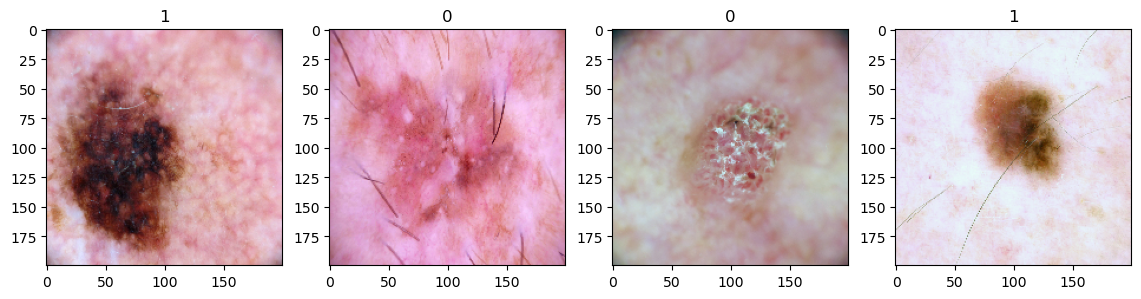

In [24]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

### Our CNN Classifier

In [25]:
def build_model(): 
    model = tf.keras.Sequential()

    # add convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))


    # add a max pooling layer with pool size (3,3) and strides of 1
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(3, 3),
        name='pool_1'))


    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        name='conv_2',
        activation='relu'))

    # add second max pooling layer with pool size (3,3) and strides of 2
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(3, 3), name='pool_2')
    )
    
    # flatten the output of the previous layers
    model.add(tf.keras.layers.Flatten()) 
    # add a fully connected layer 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.4))

    # add the last fully connected Dense layer
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))


    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 200, 200, 3))
    model.summary()
    return model

In [26]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 66, 66, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 33, 33, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 11, 11, 64)        0         
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              7930880   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy']
             ) 

In [28]:
# set random seed to get reproductible results 
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=7, 
                    validation_data=(X_val, y_val),
)

Epoch 1/7
140/140 [==============================] - 66s 465ms/step - loss: 0.6942 - accuracy: 0.5488 - val_loss: 0.6886 - val_accuracy: 0.5430
Epoch 2/7
140/140 [==============================] - 68s 487ms/step - loss: 0.6624 - accuracy: 0.5703 - val_loss: 0.6511 - val_accuracy: 0.6290
Epoch 3/7
140/140 [==============================] - 63s 453ms/step - loss: 0.6339 - accuracy: 0.6021 - val_loss: 0.6336 - val_accuracy: 0.6317
Epoch 4/7
140/140 [==============================] - 64s 455ms/step - loss: 0.5977 - accuracy: 0.6431 - val_loss: 0.6300 - val_accuracy: 0.6734
Epoch 5/7
140/140 [==============================] - 63s 452ms/step - loss: 0.5825 - accuracy: 0.6666 - val_loss: 0.6077 - val_accuracy: 0.6573
Epoch 6/7
140/140 [==============================] - 63s 452ms/step - loss: 0.5600 - accuracy: 0.6773 - val_loss: 0.5922 - val_accuracy: 0.6169
Epoch 7/7
140/140 [==============================] - 63s 446ms/step - loss: 0.5473 - accuracy: 0.6906 - val_loss: 0.5569 - val_accuracy:

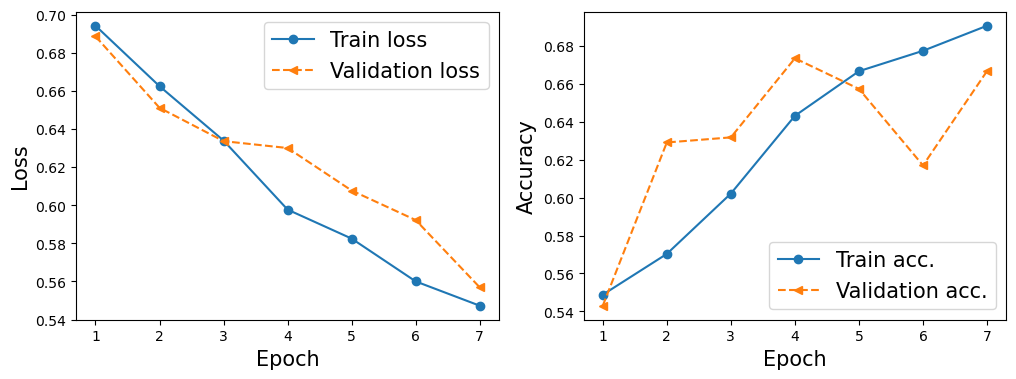

In [33]:
#Graph of Training and Validation losses of our model through each epoch, as well as test accuracy
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

#### Results vs. Baseline

In [42]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

24/24 [==============================] - 3s 111ms/step - loss: 0.5614 - accuracy: 0.6376

Test Acc. 64.00%


In [39]:
def basic(y_preds):
    "Accuracy of only  predicting that the condition is not melanoma"
    return 1- (sum(np.zeros(len(y_preds)) + y_preds) / len(y_preds))
basic(y_test)

0.4845637583892617

24/24 [==============================] - 3s 108ms/step


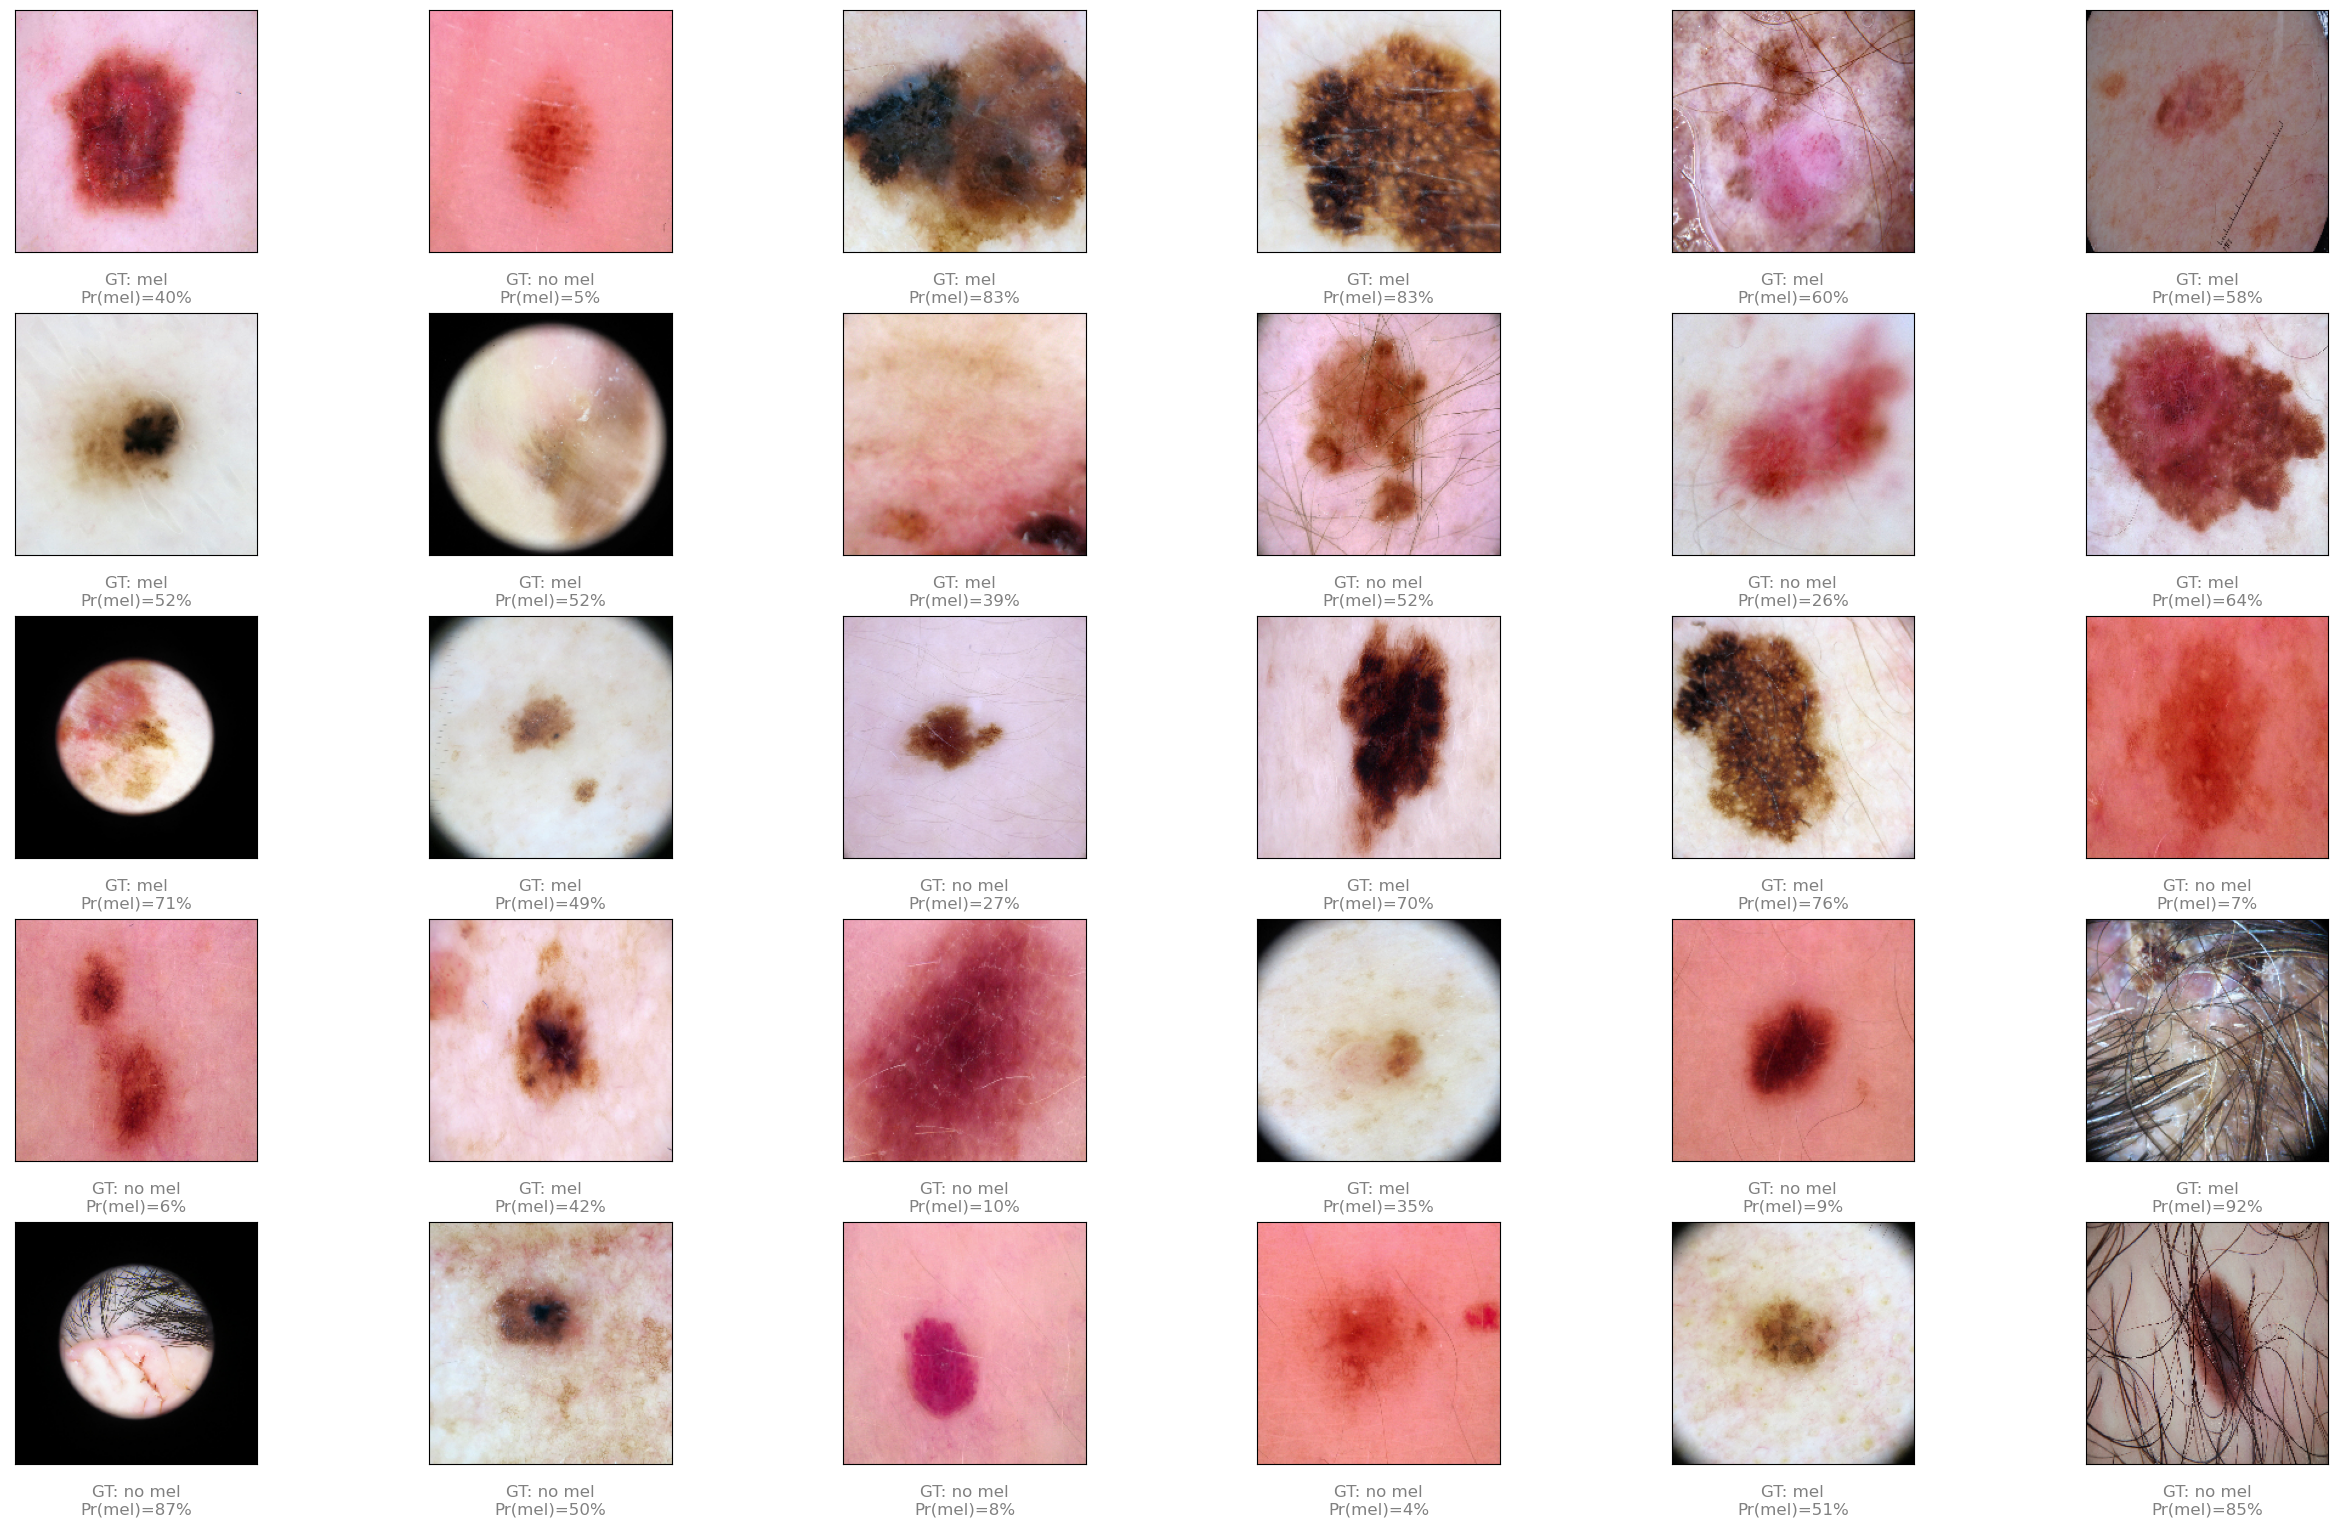

In [41]:
pred_logits = model.predict(X_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
# plot test data and associated predicred
fig = plt.figure(figsize=(25, 30))

for j, example in enumerate(X_test[:30]):
    ax = fig.add_subplot(10,6, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='no mel'
    else:
        label='mel'
    
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(mel)={:.0f}%'.format(label, probas[j]), 
        size=12, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.66              | 0.53                | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.5                | 4                | yes            |
| 0.76         | 0.69              | <font color="red">3,3</font>     | 1,1      | 2,2        | 0.001          | Adam       | 0.5                | 4                | yes            |
| 0.66            | 0.66              | 5,5          | <font color="red">2,2</font>  | 2,2        | 0.001          | Adam       | 0.5                | 4                | yes            |
| 0.66            | 0.69              | 5,5          | 1,1      | <font color="red">3,3</font>   | 0.001          | Adam       | 0.5                | 4                | yes            |
| 0.50            | 0.49              | 5,5          | 1,1      | 2,2        | <font color="red">0.01</font>       | Adam       | 0.5                | 4                | yes            |
| 0.50            | 0.49            | 5,5          | 1,1      | 2,2        | 0.001          |<font color="red">SGD</font>     | 0.5                | 4                | yes            |
| 0.54            | 0.51            | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | <font color="red">0.1</font>            | 4                | yes            |
| 0.53            | 0.52              | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.5                | <font color="red">2</font>            | yes            |
| 0.63            | 0.52              | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.5                | 4                | <font color="red">no</font>         |